In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [3]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [3]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [4]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [5]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [6]:
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [7]:
print(rel.feature_importances_)

[0.1367423  0.48858333 0.27693594 0.09773844]


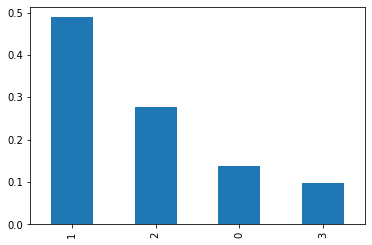

In [8]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [9]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [10]:
ordered_f.head(10)

1    0.336910
2    0.301201
0    0.060894
3    0.000000
dtype: float64

In [11]:
test_ratio = 0.2
seed = 1984
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

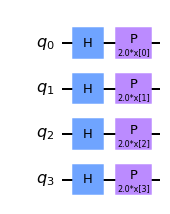

In [12]:
feature_dim = x.shape[1]
emb_layer = 1
ent = 'linear'

fmap = ZFeatureMap(feature_dimension=feature_dim, reps=emb_layer)#, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

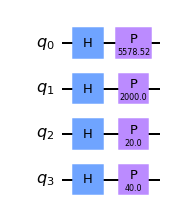

In [13]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

In [14]:
def ansatz_circ(feature_dim, layer, weights):
    ansatz = QuantumCircuit(feature_dim)
    for layer in range(layer):
        for i in range(feature_dim):
            ansatz.rx(weights[i], i)
        for i in range(feature_dim - 1):
            ansatz.cx(i, i+1)
        ansatz.cx(3,0)
        ansatz.barrier()
    return ansatz

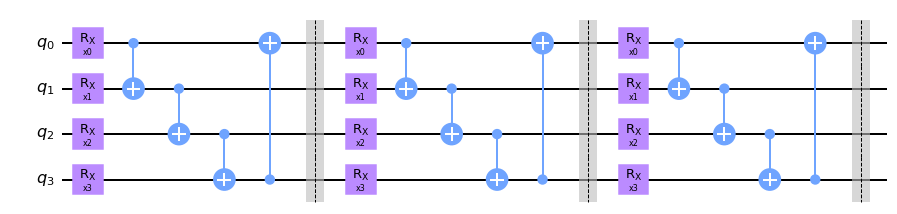

In [15]:
layer = 3
np.random.seed(seed)
nb_w = 4
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

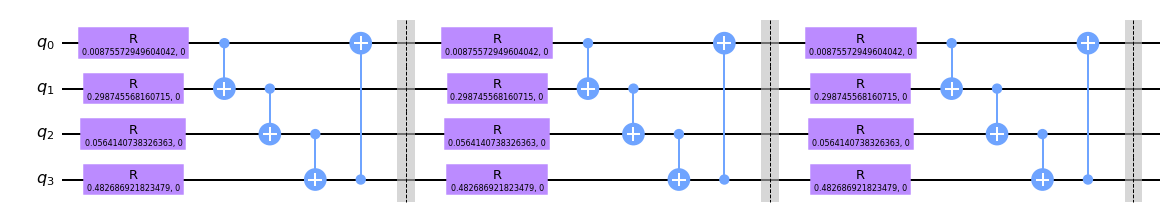

In [16]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

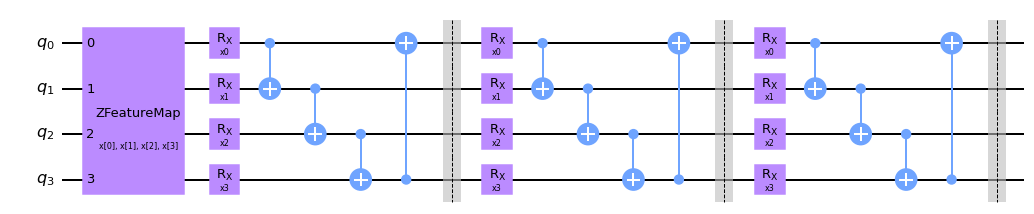

In [17]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [18]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [19]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [20]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [21]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.42285156, 0.57714844]])

In [22]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.17602539,  0.1171875 , -0.01220703, -0.37255859],
        [-0.17602539, -0.1171875 ,  0.01220703,  0.37255859]]])

In [23]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [24]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [25]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 320.7561996430014
6 - 349.78606291821603
9 - 306.85581535078245
12 - 305.7690516965783
15 - 303.31730922516084
18 - 303.19414716930805
21 - 309.37716777894946
24 - 282.29016215064155
27 - 282.69772819444677
30 - 281.5072592780853
33 - 281.71308460692546
36 - 274.569056909607
39 - 273.65550014920666
42 - 274.16382354041167
45 - 273.43684800373285
48 - 272.9540641779031
51 - 272.1699660889765
54 - 271.9992041908995
57 - 271.8458044351895
60 - 272.0198898377996
63 - 270.8471055350583
66 - 270.713169892985
69 - 269.8381300499679
72 - 269.9333277757394
75 - 269.94735000828973
78 - 270.0683102274754
81 - 269.2272550017304
84 - 269.10445848303004
87 - 269.1113979472618
90 - 269.06673472900195
93 - 268.92184707259963
96 - 268.96653655528195
99 - 269.0267504722003
102 - 269.0857006952796
105 - 268.5502727259226
108 - 268.68437061895247
111 - 268.8844814951727
114 - 268.99101423959075
117 - 268.98803300708755
120 - 268.9644594177546
123 - 269.09198380475755
126 - 268.4385282060705
129 - 268.

In [26]:
score_train_1 = vqc.score(x_train, y_train_1h)
score_test_1 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_1}')
print(f'Score on the test set {score_test_1}')

Score on the train set 0.6533333333333333
Score on the test set 0.7166666666666667


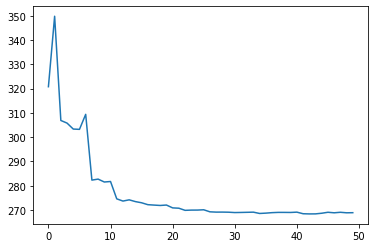

In [27]:
plt.plot(loss_recorder)

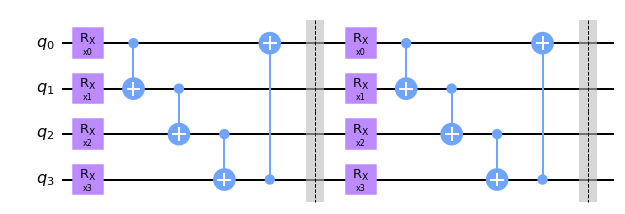

In [28]:
layer = 2
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

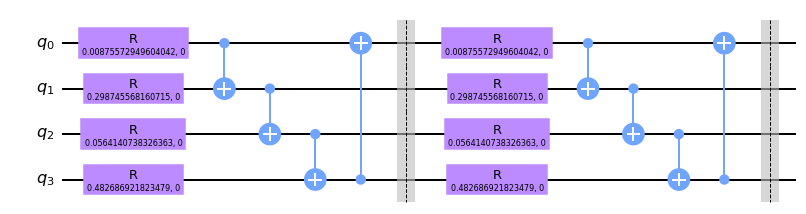

In [29]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

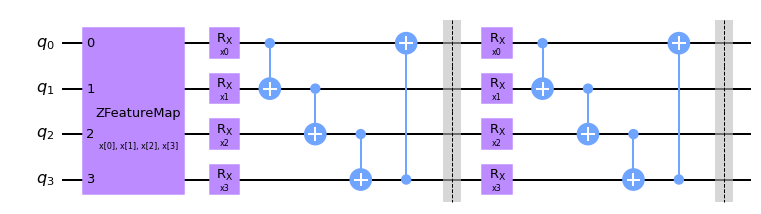

In [30]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [31]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [32]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.60595703, 0.39404297]])

In [33]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.05395508, -0.10839844, -0.01733398,  0.14233398],
        [ 0.05395508,  0.10839844,  0.01733398, -0.14233398]]])

In [34]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 299.61576798332567
6 - 298.1833023724005
9 - 308.64612128417167
12 - 300.55611240073637
15 - 299.3609990034811
18 - 298.5116579803608
21 - 298.7066247975381
24 - 300.2082729926309
27 - 299.8100975259416
30 - 307.28196533503916
33 - 304.8965266028657
36 - 309.62518864225933
39 - 300.5728603069052
42 - 300.4099322287907
45 - 298.8732732939311
48 - 298.7392730187304
51 - 298.85269042563095
54 - 298.7442332426331
57 - 298.4085783359352
60 - 299.10410451618213
63 - 298.8478559005716
66 - 298.91680500614757
69 - 298.8484483553754
72 - 298.3725464367432
75 - 298.7968215628354
78 - 298.58197939517174
81 - 298.2631419958528
84 - 298.28430207844093
87 - 298.28812757453653
90 - 298.2421606776044
93 - 298.3705116470931
96 - 298.23175764641235
99 - 298.31536022169576
102 - 298.22069978539037
105 - 298.28428744949974
108 - 298.70433497624214
111 - 298.5440490047848
114 - 298.6267065287341
117 - 298.61527223157606
120 - 298.65534208884475
123 - 298.5077843187653
126 - 298.70915258740894
129 - 298

In [35]:
score_train_2 = vqc.score(x_train, y_train_1h)
score_test_2 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_2}')
print(f'Score on the test set {score_test_2}')

Score on the train set 0.53
Score on the test set 0.5166666666666667


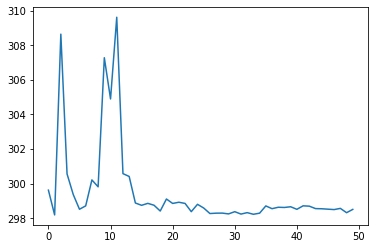

In [36]:
plt.plot(loss_recorder)

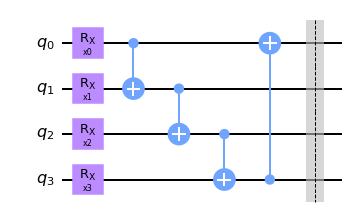

In [37]:
layer = 1
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

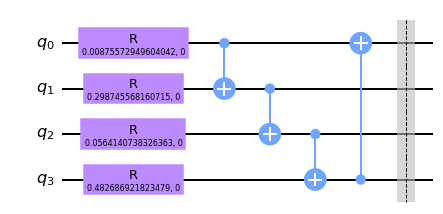

In [38]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

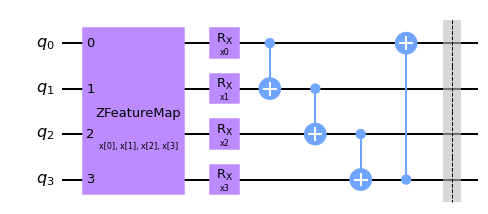

In [39]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [40]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [41]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.52294922, 0.47705078]])

In [42]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.00415039,  0.02148437,  0.04882812,  0.00317383],
        [ 0.00415039, -0.02148438, -0.04882812, -0.00317383]]])

In [43]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 299.92006746632126
6 - 299.73930181464067
9 - 300.0413270416627
12 - 299.04396569173593
15 - 299.0719967794872
18 - 298.92723547903336
21 - 297.27125667788494
24 - 296.87883615303235
27 - 298.76736505043993
30 - 299.1593352568163
33 - 299.3197700853598
36 - 297.3889719051304
39 - 298.3546240539957
42 - 298.3543440238661
45 - 298.3242978902267
48 - 298.3770231660543
51 - 297.5926399117508
54 - 297.77174084669514
57 - 297.6336842934312
60 - 297.8414236553041
63 - 298.4798134872109
66 - 298.32859647884857
69 - 297.34354187333724
72 - 297.3256263164694
75 - 297.2309548596519
78 - 297.2301756898811
81 - 297.3166870010092
84 - 297.8893309949372
87 - 298.0269059309818
90 - 298.35265449732464
93 - 297.26892168209946
96 - 297.35307792372896
99 - 297.1367887037295
102 - 296.91223772368096
105 - 296.9461577918062
108 - 296.9409534244018
111 - 297.34814320396174
114 - 297.0241273980764
117 - 296.84863506099975
120 - 296.8531906842065
123 - 296.69572896216874
126 - 296.87991661928
129 - 297.261

In [44]:
score_train_3 = vqc.score(x_train, y_train_1h)
score_test_3 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_3}')
print(f'Score on the test set {score_test_3}')

Score on the train set 0.5566666666666666
Score on the test set 0.48333333333333334


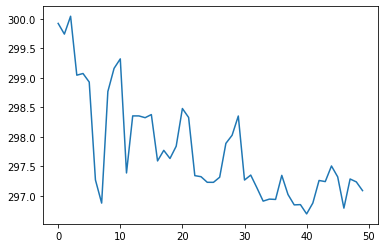

In [45]:
plt.plot(loss_recorder)